In [203]:
%matplotlib notebook
%pylab
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [204]:
#
# Different radiation antenna patterns. We consider only symmetric antenna 
# radiation patterns so each pattern is a function of a single angle between
# antenna normal and direction.
#
isotropic_rp    = lambda theta: 1.0
dipole_rp       = lambda theta: np.abs(cos(pi/2 * sin(theta)) / cos(theta))
array_dipole_rp = lambda theta, n: np.abs(sin(n * pi/2 *sin(theta)) / sin(pi/2 *sin(theta))) / n
helix_rp        = lambda theta, n: np.abs(cos(theta) * sin(n * pi/2 *cos(theta)) / sin(pi/2 *cos(theta)))

<IPython.core.display.Javascript object>


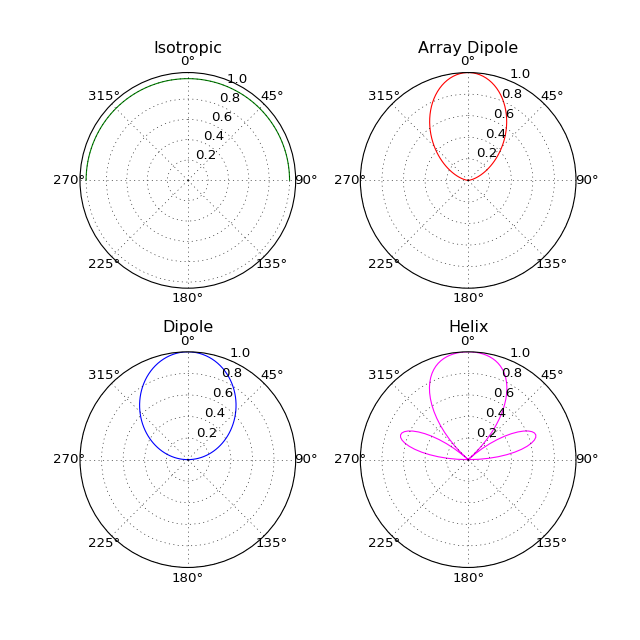

In [205]:
#
# Plotting radiation pattern of different antennas
#
theta = np.linspace(-pi/2 + 0.001, pi/2 - 0.001, num=100)
r1 = [isotropic_rp(t) for t in theta]
r2 = [dipole_rp(t) for t in theta]
r3 = [array_dipole_rp(t, 2) for t in theta]
r4 = [helix_rp(t, 3) for t in theta]

figure(1, figsize=(8,8))
ax1 = subplot2grid((2,2), (0,0), projection='polar')
ax2 = subplot2grid((2,2), (1,0), projection='polar')
ax3 = subplot2grid((2,2), (0,1), projection='polar')
ax4 = subplot2grid((2,2), (1,1), projection='polar')

ax1.plot(theta, r1, color='green', linewidth=1)
ax2.plot(theta, r2, color='blue', linewidth=1)
ax3.plot(theta, r3, color='red', linewidth=1)
ax4.plot(theta, r4, color='magenta', linewidth=1)

ax1.set_theta_zero_location('N')
ax2.set_theta_zero_location('N')
ax3.set_theta_zero_location('N')
ax4.set_theta_zero_location('N')

ax1.set_title("Isotropic", va='bottom')
ax2.set_title("Dipole", va='bottom')
ax3.set_title("Array Dipole", va='bottom')
ax4.set_title("Helix", va='bottom')

ax1.set_theta_direction(-1)
ax2.set_theta_direction(-1)
ax3.set_theta_direction(-1)
ax4.set_theta_direction(-1)

plt.subplots_adjust(wspace=0.3, hspace=0.2)
plt.show()

# ax.set_rscale('log')
# ax.set_rmax(0.008)
# ax.grid(True)

In [206]:
#
# Reflection koefficients. Each reflection koefficient depends on the material
# the reflecting ray meets. In basic case, reflection is constant, so all the
# energy fell is reflected.
#
constant_reflection = lambda alpha: -1.0

In [207]:
#
# Units conversion functions.
#
w2db = lambda w: 10.0 * log10(w)
w2dbm = lambda w: 30.0 + w2db(w)
dbm2w = lambda dbm: 10 ** ((dbm - 30.0) / 10.0)
db2w = lambda db: 10 ** (db / 10)

In [208]:
#
# Definining reader, tag and wireless transmission, or environment, parameters.
#

# environment parameters
speed_of_light = 2.99792458 * 10e8
frequency = 860*10e6
wave_length = speed_of_light / frequency
ground_reflection = constant_reflection
thermal_noise = -116 #dBm

# reader paramters
reader_height = 5.0
reader_angle  = pi/4
reader_tx_power = 31.5 #dBm
reader_antenna_gain = 8 #dBi
reader_noise  = -80 #dBm
reader_cabel_loss = -2 
reader_input_loss = 0 #dB cabel loss
reader_rp = lambda alpha: dipole_rp(alpha - reader_angle)

# tag parameters 
tag_height = 0.5 
tag_angle  = pi/2
tag_antenna_gain = 2 #dBi
tag_polarization_loss = -6.0 #dB 
tag_modulation_loss = -6.0 #dB
tag_sensitivity=-18.5 #dBm
tag_rp = lambda alpha: dipole_rp(alpha - tag_angle)

In [209]:
#
# Path loss computing. First function performs free-space path loss computation and
# the second one performs two-ray path loss considering ground reflection
#
def FSPL(distance):
    d0 = sqrt((reader_height - tag_height)**2 + distance**2)
    alpha0 = arctan(distance / (reader_height - tag_height))
    g0 = reader_rp(alpha0) * tag_rp(alpha0)
    K = wave_length / (4*pi)
    return (K*g0/d0)**2
    
def R2PL(distance):
    d0 = sqrt((reader_height - tag_height)**2 + distance**2)
    d1 = sqrt((reader_height + tag_height)**2 + distance**2)
    alpha0 = arctan(distance / (reader_height - tag_height))
    alpha1 = arctan(distance / (reader_height + tag_height))
    g0 = reader_rp(alpha0) * tag_rp(alpha0)
    g1 = reader_rp(alpha1) * tag_rp(alpha1)
    r = ground_reflection(alpha1)
    K = wave_length / (4*pi)
    return K**2 * ((g0/d0)**2 + (g1*r/d1)**2 + 2*(g0*g1*r) / (d0*d1)*cos((d1-d0)/(2*K)))

<IPython.core.display.Javascript object>


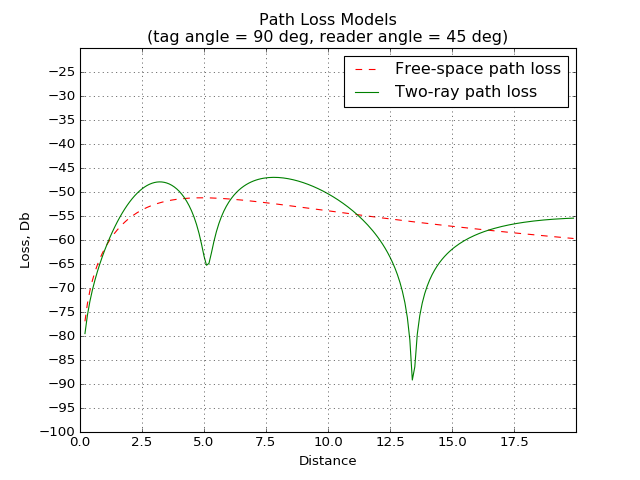

In [210]:
d = arange(0.2, 20, 0.1)

fig = figure(2)
ax = subplot(111)
plot(d, w2db(FSPL(d)), 'r--', label='Free-space path loss')
plot(d, w2db(R2PL(d)), 'g',   label='Two-ray path loss')
grid(True)
ax.set_ybound(lower=-100, upper=-20)
ax.set_xticks(arange(0, 20, 2.5))
ax.set_yticks(arange(-100, -20, 5))
ax.set_xlabel("Distance")
ax.set_ylabel("Loss, Db")
ax.set_title('Path Loss Models\n(tag angle = 90 deg, reader angle = 45 deg)')
legend()

In [211]:
def rx_power_tag(distance):
    return (reader_tx_power + reader_antenna_gain + reader_cabel_loss + 
            w2db(R2PL(distance)) + tag_antenna_gain + tag_polarization_loss)

def tx_power_tag(distance):
    rx = rx_power_tag(distance)
    if rx >= tag_sensitivity:
#         return rx + node_p.modulation_loss
        return rx - 12 #+ rx * (-11/16)
    else:
        return thermal_noise

def rx_power_reader(distance):    
    tx = tx_power_tag(distance)
    if tx <= reader_noise:
        return thermal_noise
    else:
        return (tx + tag_antenna_gain + w2db(R2PL(distance)) + 
                reader_cabel_loss  + reader_antenna_gain + reader_input_loss)

<IPython.core.display.Javascript object>


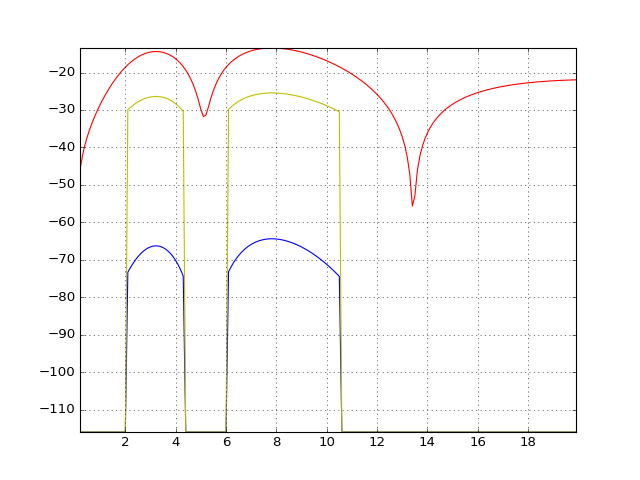

In [212]:
fig = figure(3)
ax = subplot(111)
ax.set_xticks(arange(0, 20, 2))
ax.set_yticks(arange(-110, 30, 10))
ax.set_ybound(lower=-110, upper=30)
plot(d, [rx_power_tag(dx) for dx in d], 'r', label='RX at tag (forward)')
plot(d, [rx_power_reader(dx) for dx in d], 'b', label='RX at reader (backscattered)')
plot(d, [tx_power_tag(dx) for dx in d], 'y', label='TX tag')
grid(True)
# legend()

In [267]:
from scipy.special import erf

Q = lambda x: 0.5 - 0.5 * erf(x / np.sqrt(2))

def snr(distance):
#     return db2k(RX_reader(distance, node_a, node_p, env, PL) - node_a.tx_power + 20)
     return dbm2w(rx_power_reader(distance)) / dbm2w(reader_noise)

def ber_over_awgn(snr, m, decibel_snr=False):
    if not decibel_snr:
        y = 2*Q(sqrt(m*snr))*(1 - Q(sqrt(m*snr)))
        return y
    else:
        return 2*Q(sqrt(m*db2k(snr)))*(1 - Q(sqrt(m*db2k(snr))))

def ber_over_Rayleigh(snr, miller = 1, sync_phi = 0, symbol_duration = 0.125e-6, bandwidth = 10e6):
    gamma = miller * snr * symbol_duration * bandwidth * cos(sync_phi) ** 2
    t = sqrt(1 + 2/(gamma))
    return 0.5 - 1/t + 2/pi * arctan(t)/t

<IPython.core.display.Javascript object>


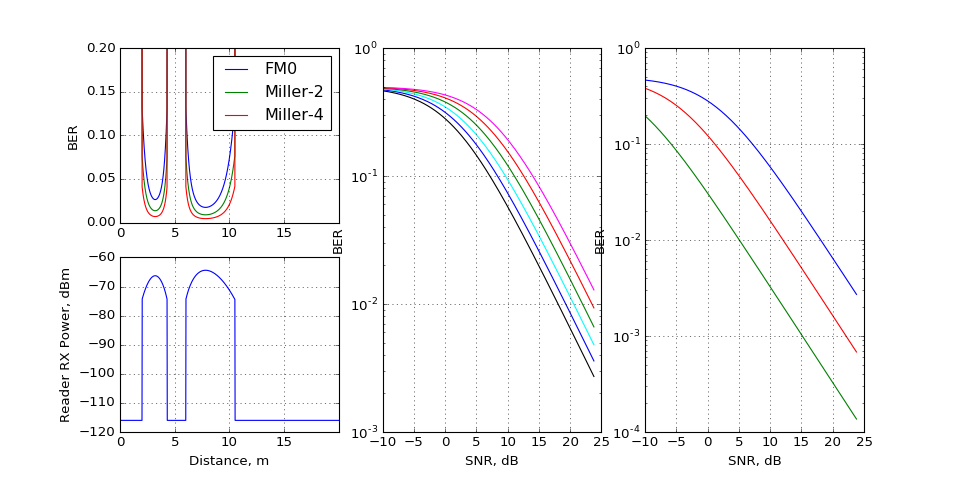

In [268]:
d = arange(0.1, 20, 0.01)
fig = figure(4, figsize=(12,6))
ax1 = subplot2grid((2,3), (0,0))
ax2 = subplot2grid((2,3), (1,0))
ax3 = subplot2grid((2,3), (0,1), rowspan=2)
ax4 = subplot2grid((2,3), (0,2), rowspan=2)

ax1.plot(d, [ber_over_Rayleigh(snr(dx), miller=1) for dx in d], label='FM0')
ax1.plot(d, [ber_over_Rayleigh(SNR(dx), miller=2) for dx in d], label='Miller-2')
ax1.plot(d, [ber_over_Rayleigh(SNR(dx), miller=4) for dx in d], label='Miller-4')
ax1.plot(d, [ber_over_Rayleigh(SNR(dx), miller=4, symbol_duration=2.5e-6) for dx in d], label='Miller-4')
# ax3.plot(snr_array, ber_over_Rayleigh(db2w(snr_array), 1, sync_phi=pi/2*0.46), color='cyan')
# ax1.set_yscale('log')
ax1.legend()
ax1.set_ybound(lower=0, upper=0.2)
# ax1.set_ybound(lower=10e-7, upper=10e15)
ax1.grid(True)
ax1.set_xticks(arange(0, 20, 5))
ax1.set_ylabel('BER')

ax2.plot(d, [rx_power_reader(dx) for dx in d])
ax2.grid(True)
ax2.set_xticks(arange(0, 20, 5))
ax2.set_ylabel('Reader RX Power, dBm')
ax2.set_xlabel('Distance, m')

snr_array = arange(-10, 24, 0.2)
ax3.plot(snr_array, ber_over_Rayleigh(db2w(snr_array), 1), color='black')
ax3.plot(snr_array, ber_over_Rayleigh(db2w(snr_array), 1, sync_phi=pi/2*0.33), color='blue')
ax3.plot(snr_array, ber_over_Rayleigh(db2w(snr_array), 1, sync_phi=pi/2*0.46), color='cyan')
ax3.plot(snr_array, ber_over_Rayleigh(db2w(snr_array), 1, sync_phi=pi/2*0.56), color='green')
ax3.plot(snr_array, ber_over_Rayleigh(db2w(snr_array), 1, sync_phi=pi/2*0.64), color='red')
ax3.plot(snr_array, ber_over_Rayleigh(db2w(snr_array), 1, sync_phi=pi/2*0.70), color='magenta')
ax3.set_yscale('log')
ax3.grid(True)
ax3.set_ylabel('BER')
ax3.set_xlabel('SNR, dB')

ax4.plot(snr_array, ber_over_Rayleigh(db2w(snr_array), 1), color='blue')
ax4.plot(snr_array, ber_over_Rayleigh(db2w(snr_array), 1, symbol_duration=2.5e-6), color='green')
ax4.plot(snr_array, ber_over_Rayleigh(db2w(snr_array), 4), color='red')
ax4.set_yscale('log')
ax4.grid(True)
ax4.set_ylabel('BER')
ax4.set_xlabel('SNR, dB')